In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from collections import Counter

### Load dataset

In [2]:
series = pd.read_csv('zillow-carlifornia .csv', parse_dates=True,
squeeze=True)

In [3]:
series.columns = [ 'Date', 'MedianSoldPrice', 'MedianMortageRate', 'UnemploymentRate', 'MedianRentalPrice']
series.head()

,Date,MedianSoldPrice,MedianMortageRate,UnemploymentRate,MedianRentalPrice
0,2004-01-31,326752.55,5.02,7.9,NaN
1,2004-02-29,329501.50,4.94,7.8,NaN
2,2004-03-31,340125.45,4.74,7.8,NaN
3,2004-04-30,355329.50,5.16,7.5,NaN
4,2004-05-31,367818.15,5.64,7.3,NaN


#### impute missing MedianRentalPrice_AllHomes data with median value

In [4]:
medianRental = series['MedianRentalPrice']
median_val = np.median(medianRental.loc[~medianRental.isna()])
series['MedianRentalPrice'] = medianRental.fillna(median_val)
series.head()

,Date,MedianSoldPrice,MedianMortageRate,UnemploymentRate,MedianRentalPrice
0,2004-01-31,326752.55,5.02,7.9,2100.0
1,2004-02-29,329501.50,4.94,7.8,2100.0
2,2004-03-31,340125.45,4.74,7.8,2100.0
3,2004-04-30,355329.50,5.16,7.5,2100.0
4,2004-05-31,367818.15,5.64,7.3,2100.0


#### Train-test split

In [5]:
test_set = series[series['MedianSoldPrice'].isna()]

In [6]:
train_set = series[~series['MedianSoldPrice'].isna()]

In [7]:
train_set.head()

,Date,MedianSoldPrice,MedianMortageRate,UnemploymentRate,MedianRentalPrice
0,2004-01-31,326752.55,5.02,7.9,2100.0
1,2004-02-29,329501.50,4.94,7.8,2100.0
2,2004-03-31,340125.45,4.74,7.8,2100.0
3,2004-04-30,355329.50,5.16,7.5,2100.0
4,2004-05-31,367818.15,5.64,7.3,2100.0


### Line plot

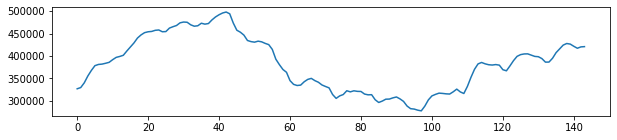

In [8]:
median_sold = train_set['MedianSoldPrice']
fig = plt.figure(figsize=(10, 2))
pyplot.plot(median_sold)
pyplot.show()

There seems to be an increasing then decreasing trend, seasonality exists in the later half

### Time differencing to eliminate trend

##### d=1

In [9]:
X = train_set['MedianSoldPrice']
d1 = list()
for i in range(1, len(X)):
    value = X[i] - X[i - 1]
    d1.append(value)

In [10]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
adf_test(d1)

Results of Dickey-Fuller Test:
Test Statistic                  -1.687305
p-value                          0.437665
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


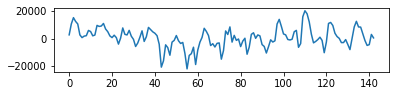

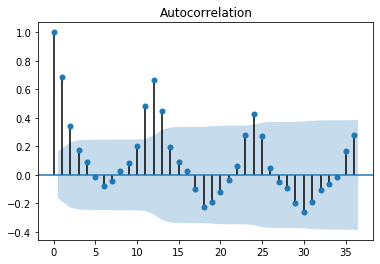

/Users/aakanksha/miniconda3/envs/LR/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


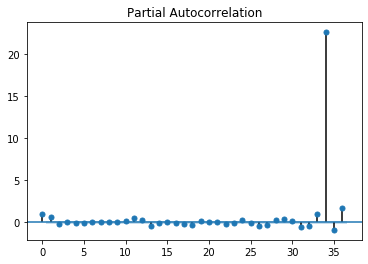

In [11]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.subplot(3,1,1)
plt.plot(d1) 
plt.show()
plot_acf(d1,lags=36) 
plt.show()
plot_pacf(d1,lags=36) 
plt.show()

##### d=2

In [12]:
d2 = list()
for i in range(1, len(d1)):
    value = d1[i] - d1[i - 1]
    d2.append(value)

In [13]:
adf_test(d2)

Results of Dickey-Fuller Test:
Test Statistic                  -4.918846
p-value                          0.000032
#Lags Used                      11.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


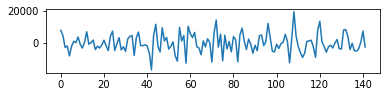

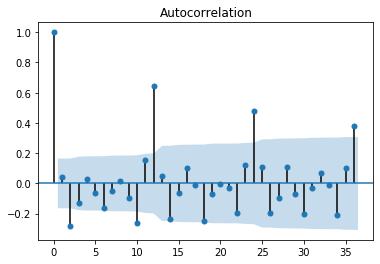

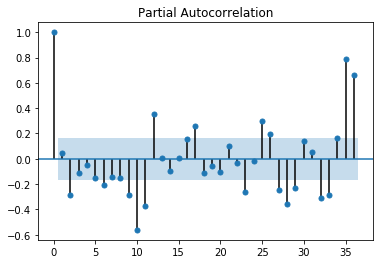

In [14]:
plt.subplot(3,1,1)
plt.plot(d2) 
plt.show()
plot_acf(d2,lags=36) 
plt.show()
plot_pacf(d2,lags=36) 
plt.show()

### Model Selection

In [15]:
train_size = int(len(X) * 0.85)
train, test = X[:train_size], X[train_size:]
train.head()

0    326752.55
1    329501.50
2    340125.45
3    355329.50
4    367818.15
Name: MedianSoldPrice, dtype: float64

##### ARIMA

In [16]:
import pmdarima as pm
model = pm.auto_arima(train, start_p=1, start_q=1,
                           max_p=3, max_q=3, 
                           start_P=0, seasonal=True,
                           d=1,D=2, m=12,  trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(model.summary())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 2, 1, 12); AIC=1955.260, BIC=1968.134, Fit time=1.268 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 2, 0, 12); AIC=2036.314, BIC=2041.464, Fit time=0.019 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 2, 0, 12); AIC=2045.398, BIC=2055.697, Fit time=0.278 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 2, 1, 12); AIC=1980.386, BIC=1990.685, Fit time=0.278 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 2, 1, 12); AIC=1957.283, BIC=1972.732, Fit time=1.782 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 2, 0, 12); AIC=2043.602, BIC=2053.901, Fit time=0.239 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 2, 2, 12); AIC=1962.842, BIC=1978.290, Fit time=1.253 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 2, 2, 12); AIC=1963.995, BIC=1982.018, Fit time=3.328 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 2, 1, 12); AIC=1948.400, BIC=1963.848, Fit time=1.571 seconds
Fit ARIMA: order=(2, 1, 0) s

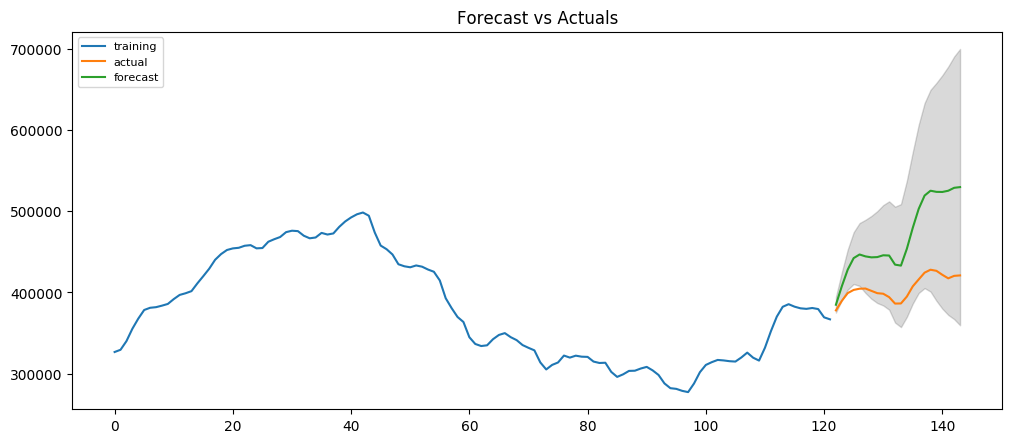

In [17]:
fitted = model.fit(train)
fc, conf = fitted.predict(len(test),return_conf_int=True,alpha=0.05)
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [18]:
mse = ((fc_series - test) ** 2).mean()
rmse=np.sqrt(mse)
print(rmse)

70291.93479019073


##### SARIMAX - MedianMortageRate only

In [19]:
sarimax_data=train_set[['MedianMortageRate']]
exog_train=sarimax_data[:train_size]
exog_test=sarimax_data[train_size:]

In [20]:
modelx = SARIMAX(train, order=(1, 2, 1), seasonal_order=(0,1,0,12),exog=exog_train)
fitx=modelx.fit()
print(fitx.summary())

                                 Statespace Model Results                                 
Dep. Variable:                    MedianSoldPrice   No. Observations:                  122
Model:             SARIMAX(1, 2, 1)x(0, 1, 0, 12)   Log Likelihood               -1061.990
Date:                            Tue, 03 Dec 2019   AIC                           2131.980
Time:                                    21:24:18   BIC                           2142.709
Sample:                                         0   HQIC                          2136.330
                                            - 122                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
MedianMortageRate  2759.0863   1445.853      1.908      0.056     -74.734    5592.907
ar.L1         

In [21]:
fc = fitx.predict(start=122, end=143, exog=exog_test)

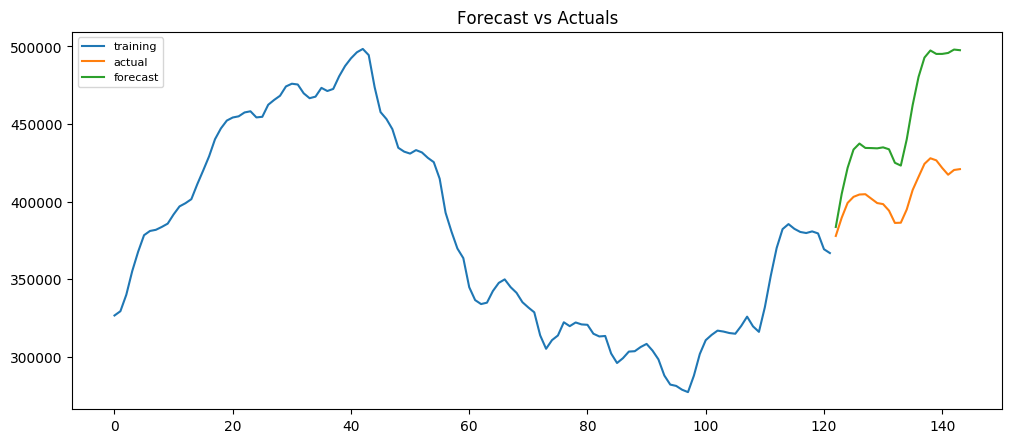

In [22]:
fc_series = pd.Series(fc)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [23]:
mse = ((fc_series - test) ** 2).mean()
rmse=np.sqrt(mse)
print(rmse)

51575.15317617445


In [24]:
#auto select orders


model = pm.auto_arima(train, exogenous=exog_train, start_p=1, start_q=1,
                           max_p=3, max_q=3, 
                           start_P=0, seasonal=True,
                            D=2,m=12, d=1,  trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(model.summary())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 2, 1, 12); AIC=1955.185, BIC=1970.633, Fit time=1.609 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 2, 0, 12); AIC=2037.589, BIC=2045.313, Fit time=0.027 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 2, 0, 12); AIC=2046.931, BIC=2059.804, Fit time=0.355 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 2, 1, 12); AIC=1981.107, BIC=1993.981, Fit time=0.373 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 2, 1, 12); AIC=1957.317, BIC=1975.340, Fit time=1.989 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 2, 0, 12); AIC=2045.151, BIC=2058.025, Fit time=0.193 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 2, 2, 12); AIC=1962.696, BIC=1980.719, Fit time=1.522 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 2, 2, 12); AIC=1963.554, BIC=1984.152, Fit time=4.321 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 2, 1, 12); AIC=1947.863, BIC=1965.886, Fit time=2.122 seconds
Fit ARIMA: order=(2, 1, 0) s

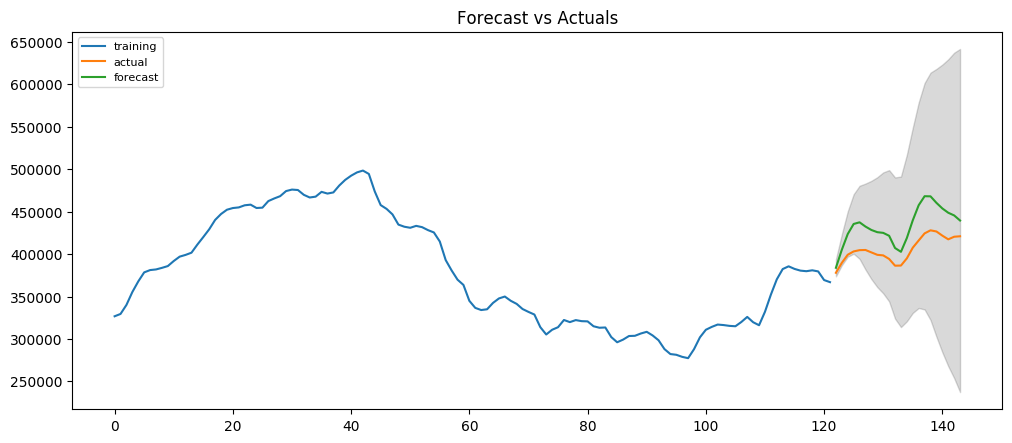

In [25]:
fitted = model.fit(train)
fc, conf = fitted.predict(len(test),return_conf_int=True,alpha=0.05)
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [26]:
mse = ((fc_series - test) ** 2).mean()
rmse=np.sqrt(mse)
print(rmse)

28826.655043105908


##### VAR - all variables

In [27]:
#VAR
var_series =train_set[['MedianSoldPrice', 'MedianMortageRate', 'UnemploymentRate', 'MedianRentalPrice']]
train = var_series[:int(0.75*(len(var_series)))]
test = var_series[int(0.75*(len(var_series))):]
train.head()

,MedianSoldPrice,MedianMortageRate,UnemploymentRate,MedianRentalPrice
0,326752.55,5.02,7.9,2100.0
1,329501.50,4.94,7.8,2100.0
2,340125.45,4.74,7.8,2100.0
3,355329.50,5.16,7.5,2100.0
4,367818.15,5.64,7.3,2100.0


In [28]:
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train)
model_fit = model.fit(2)
print(model_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 03, Dec, 2019
Time:                     21:24:54
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    21.3993
Nobs:                     106.000    HQIC:                   20.8614
Log likelihood:          -1651.85    FPE:                7.97021e+08
AIC:                      20.4948    Det(Omega_mle):     5.75310e+08
--------------------------------------------------------------------
Results for equation MedianSoldPrice
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                    -5629.538706     10307.019651           -0.546           0.585
L1.MedianSoldPrice           1.609540         0.080406           20.018           0.000
L1.MedianMortageRate  

In [29]:
fc = model_fit.forecast(model_fit.y, steps=len(test))
cols = var_series.columns
pred = pd.DataFrame(index=test.index,columns=cols)
for j in range(0,2):
    for i in range(0, len(fc)):
        pred.iloc[i][j] = fc[i][j]

/Users/aakanksha/miniconda3/envs/LR/lib/python3.7/site-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


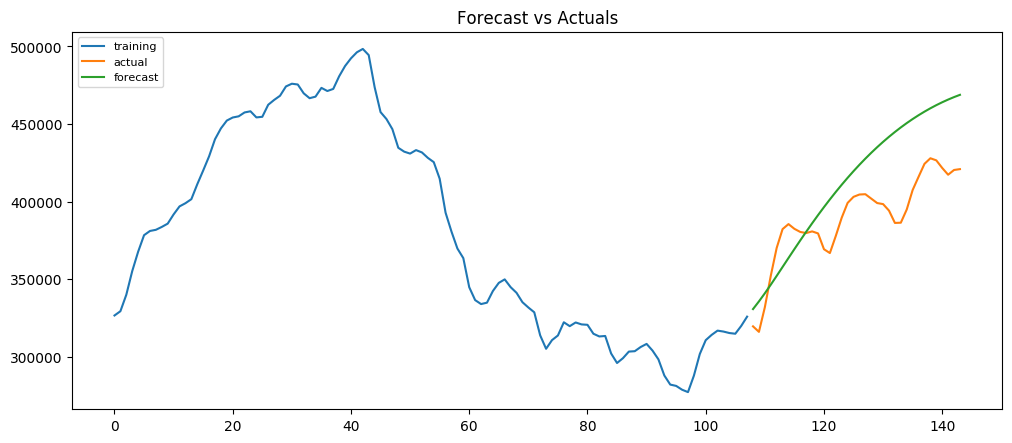

In [30]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['MedianSoldPrice'], label='training')
plt.plot(test['MedianSoldPrice'], label='actual')
plt.plot(pred['MedianSoldPrice'], label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [31]:
mse = ((pd.Series(pred['MedianSoldPrice']) - test['MedianSoldPrice']) ** 2).mean()
rmse=np.sqrt(mse)
print(rmse)

32929.60225091285


#### VAR - medianMortgage, unemployment

In [32]:
var_series =train_set[['MedianSoldPrice', 'MedianMortageRate', 'UnemploymentRate']]
train = var_series[:int(0.75*(len(var_series)))]
test = var_series[int(0.75*(len(var_series))):]
train.head()

,MedianSoldPrice,MedianMortageRate,UnemploymentRate
0,326752.55,5.02,7.9
1,329501.50,4.94,7.8
2,340125.45,4.74,7.8
3,355329.50,5.16,7.5
4,367818.15,5.64,7.3


In [33]:
model = VAR(endog=train)
model_fit = model.fit(2)
print(model_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 03, Dec, 2019
Time:                     21:24:55
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    12.9060
Nobs:                     106.000    HQIC:                   12.5922
Log likelihood:          -1086.28    FPE:                    237744.
AIC:                      12.3784    Det(Omega_mle):         196242.
--------------------------------------------------------------------
Results for equation MedianSoldPrice
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                    -8712.160935      9795.139153           -0.889           0.374
L1.MedianSoldPrice           1.633847         0.077860           20.984           0.000
L1.MedianMortageRate  

In [34]:
fc = model_fit.forecast(model_fit.y, steps=len(test))
cols = var_series.columns
pred = pd.DataFrame(index=test.index,columns=cols)
for j in range(0,2):
    for i in range(0, len(fc)):
        pred.iloc[i][j] = fc[i][j]

/Users/aakanksha/miniconda3/envs/LR/lib/python3.7/site-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


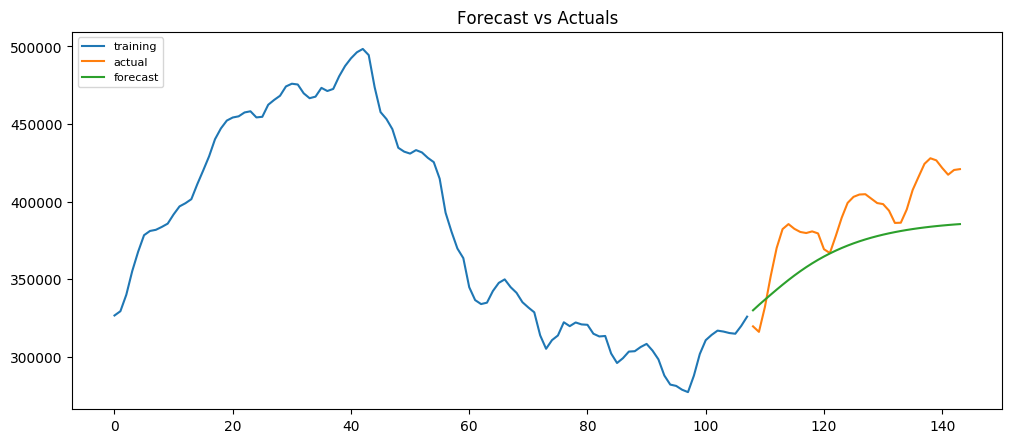

In [35]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['MedianSoldPrice'], label='training')
plt.plot(test['MedianSoldPrice'], label='actual')
plt.plot(pred['MedianSoldPrice'], label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [36]:
mse = ((pd.Series(pred['MedianSoldPrice']) - test['MedianSoldPrice']) ** 2).mean()
rmse=np.sqrt(mse)
print(rmse)

26080.438494704806


### VAR - medianMortgage, AR2

In [37]:
var_series =train_set[['MedianSoldPrice', 'MedianMortageRate']]
train = var_series[:int(0.75*(len(var_series)))]
test = var_series[int(0.75*(len(var_series))):]
train.head()

,MedianSoldPrice,MedianMortageRate
0,326752.55,5.02
1,329501.50,4.94
2,340125.45,4.74
3,355329.50,5.16
4,367818.15,5.64


In [38]:
model = VAR(endog=train)
model_fit = model.fit(2)
print(model_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 03, Dec, 2019
Time:                     21:24:55
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    13.8614
Nobs:                     106.000    HQIC:                   13.7120
Log likelihood:          -1012.15    FPE:                    814493.
AIC:                      13.6102    Det(Omega_mle):         742768.
--------------------------------------------------------------------
Results for equation MedianSoldPrice
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                     4421.520569      3000.020890            1.474           0.141
L1.MedianSoldPrice           1.660193         0.075275           22.055           0.000
L1.MedianMortageRate  

In [39]:
fc = model_fit.forecast(model_fit.y, steps=len(test))
cols = var_series.columns
pred = pd.DataFrame(index=test.index,columns=cols)
for j in range(0,2):
    for i in range(0, len(fc)):
        pred.iloc[i][j] = fc[i][j]

/Users/aakanksha/miniconda3/envs/LR/lib/python3.7/site-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


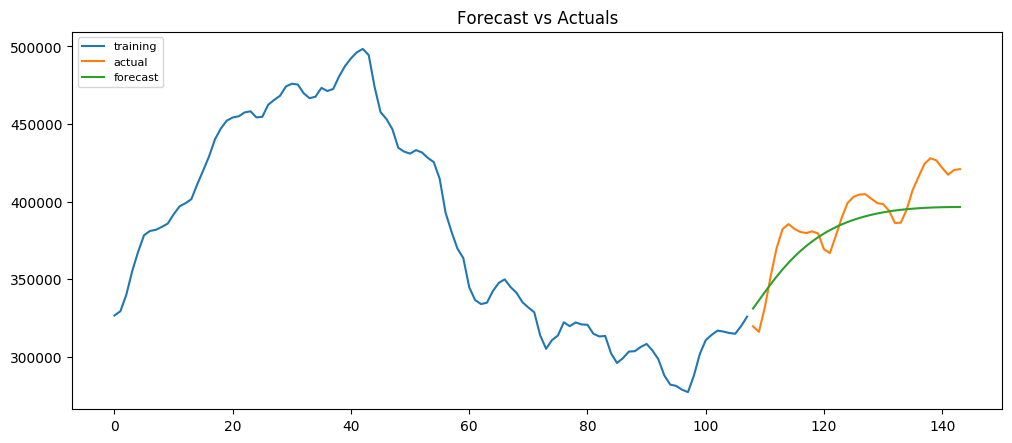

In [40]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['MedianSoldPrice'], label='training')
plt.plot(test['MedianSoldPrice'], label='actual')
plt.plot(pred['MedianSoldPrice'], label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [41]:
mse = ((pd.Series(pred['MedianSoldPrice']) - test['MedianSoldPrice']) ** 2).mean()
rmse=np.sqrt(mse)
print(rmse)

16579.898172621302


In [42]:
model = VAR(endog=train)
model_fit = model.fit(1)
print(model_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 03, Dec, 2019
Time:                     21:24:55
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.3703
Nobs:                     107.000    HQIC:                   14.2812
Log likelihood:          -1058.45    FPE:                1.49923e+06
AIC:                      14.2204    Det(Omega_mle):     1.41857e+06
--------------------------------------------------------------------
Results for equation MedianSoldPrice
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                     3459.301759      4050.322252            0.854           0.393
L1.MedianSoldPrice           1.023720         0.024570           41.666           0.000
L1.MedianMortageRate  

In [43]:
fc = model_fit.forecast(model_fit.y, steps=len(test))
cols = var_series.columns
pred = pd.DataFrame(index=test.index,columns=cols)
for j in range(0,2):
    for i in range(0, len(fc)):
        pred.iloc[i][j] = fc[i][j]

/Users/aakanksha/miniconda3/envs/LR/lib/python3.7/site-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


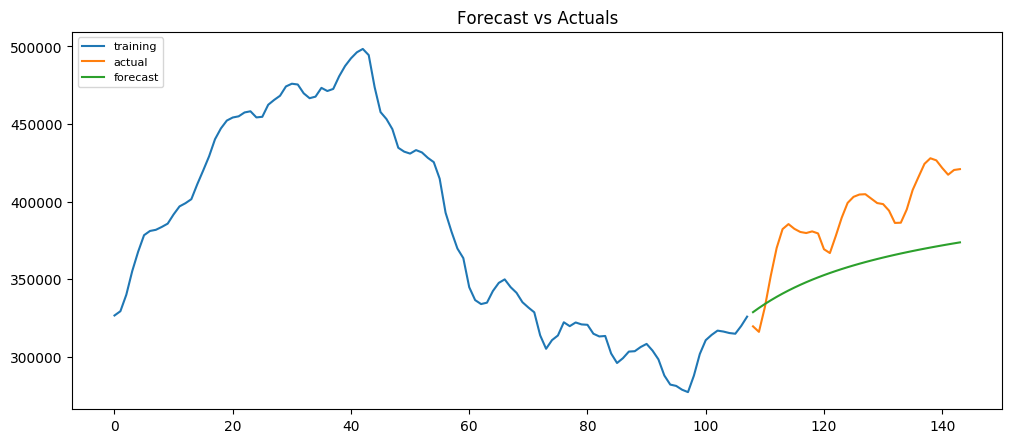

In [44]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['MedianSoldPrice'], label='training')
plt.plot(test['MedianSoldPrice'], label='actual')
plt.plot(pred['MedianSoldPrice'], label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [45]:
mse = ((pd.Series(pred['MedianSoldPrice']) - test['MedianSoldPrice']) ** 2).mean()
rmse=np.sqrt(mse)
print(rmse)

36763.53291571027
